In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch
import numpy as np
import pandas as pd

In [5]:
url = "https://raw.githubusercontent.com/Imrauviel/Bert-Model-Comparison/main/datasets/ready_data_filmweb_200_eq.csv"
df_filmweb = pd.read_csv(url)
df_filmweb

,title,description,genre
0,finding dory,Zapominalska morska rybka Dory udaje się w pod...,animation
1,pawn,Kiedy uzbrojeni bandyci napadają na bar i bior...,crime
2,french kiss,"Kate udaje się za narzeczonym do Paryża, aby u...",comedy
3,into the inferno,Werner Herzog i jego przyjaciel&nbsp;Clive Opp...,documentary
4,hauru no ugoku shiro,"Sophie, zmieniona przez czarownicę w staruszkę...",fantasy
...,...,...,...
2195,fasandrberne,"Rok 1994, zabite zostają bliźnięta, a do zbrod...",crime
2196,skazka skazok,Samotnie stojący dom zostaje opuszczony przez...,animation
2197,the pink panther 2,Inspektor Jacques Clouseau współpracuje z podo...,comedy
2198,cabin fever,Grupa znajomych przyjeżdża do małego domku w g...,horror


In [6]:
le = LabelEncoder()
df_filmweb["genre"] = le.fit_transform(df_filmweb["genre"])

In [7]:
filmweb_data = Dataset.from_pandas(df_filmweb)

In [8]:
filmweb_data.set_format(type="pandas")

In [9]:
df_filmweb = filmweb_data[:]

In [10]:
df_filmweb

,title,description,genre
0,finding dory,Zapominalska morska rybka Dory udaje się w pod...,1
1,pawn,Kiedy uzbrojeni bandyci napadają na bar i bior...,4
2,french kiss,"Kate udaje się za narzeczonym do Paryża, aby u...",3
3,into the inferno,Werner Herzog i jego przyjaciel&nbsp;Clive Opp...,5
4,hauru no ugoku shiro,"Sophie, zmieniona przez czarownicę w staruszkę...",8
...,...,...,...
2195,fasandrberne,"Rok 1994, zabite zostają bliźnięta, a do zbrod...",4
2196,skazka skazok,Samotnie stojący dom zostaje opuszczony przez...,1
2197,the pink panther 2,Inspektor Jacques Clouseau współpracuje z podo...,3
2198,cabin fever,Grupa znajomych przyjeżdża do małego domku w g...,9


In [11]:
filmweb_data.reset_format()

In [12]:
model_ckpt = "allegro/herbert-base-cased"
model_ckpt_eng = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
def tokenize(batch):
    return tokenizer(batch["description"], padding=True, truncation=True)


In [14]:
filmweb_data_encoded = filmweb_data.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
text = "Ta książka jest super"
text_eng = "Hello I Love you"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [18]:
inputs = {k:v.to(device) for k,v in inputs.items()}
inputs

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0'),
 'input_ids': tensor([[    0,  5539, 13428,  2092, 24583,     2]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]], device='cuda:0')}

In [19]:
with torch.no_grad():
    outputs = model(**inputs)

In [20]:
print(outputs["last_hidden_state"][:, 0].shape)

torch.Size([1, 768])


In [21]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
                if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs)["last_hidden_state"]
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [22]:
filmweb_data_encoded.set_format("torch", columns=["input_ids", "attention_mask", "genre", "token_type_ids"])

In [23]:
filmweb_data_hidden = filmweb_data_encoded.map(extract_hidden_states, batched=True, batch_size=32)

  0%|          | 0/69 [00:00<?, ?ba/s]

In [24]:
## I know that I haven't split the data between train and test before running BERT but I think that if we're not updating
## the weights then we do not have to do it beforehand, because there wil be no data leakage either way

In [25]:
X_train, X_test, y_train, y_test = train_test_split(filmweb_data_hidden["hidden_state"], filmweb_data_hidden["genre"], test_size=0.2, stratify=filmweb_data_hidden["genre"])

In [26]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import CondensedNearestNeighbour, NeighbourhoodCleaningRule

In [27]:
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [28]:
# Counter(y_resampled)

In [29]:
filmweb_data_hidden["hidden_state"].numpy()

array([[-0.18975061, -0.11079542,  0.17297935, ..., -0.8549208 ,
         0.04646337,  0.14408904],
       [-0.02417988, -0.04340373, -0.06607238, ..., -0.20377038,
         0.07733601, -0.3137771 ],
       [ 0.29483667, -0.21301998, -0.15152797, ..., -0.23812956,
         0.1895005 , -0.01106715],
       ...,
       [ 0.27559966, -0.10253435, -0.08085758, ..., -0.7960997 ,
        -0.16179216,  0.4706858 ],
       [ 0.16040565, -0.25504348,  0.08413205, ..., -0.10147966,
         0.07337528,  0.16830443],
       [-0.04296774, -0.19026557,  0.05547074, ...,  0.00713325,
         0.03663961, -0.3560608 ]], dtype=float32)

### Classifiers

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import pandas as pd

In [31]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrixs(y_preds, y_true, labels, model_names):
    
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(40, 50))
    for i, y_pred in enumerate(y_preds):
        cm = confusion_matrix(y_true, y_pred, normalize="true")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap="Blues", values_format=".2f", ax=ax[i], colorbar=False)
        ax[i].set_title(model_names[i])
        plt.title(f"Normalized confusion matrix - {model_names[i]}")
        print(f"Accuracy for {model_names[i]}: {accuracy_score(y_true, y_pred)}")
    plt.show()
    

In [33]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
    # "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42)
}

In [34]:
def train_and_evaluate(dataset_filmweb, dataset_imdb):
    
    X_filmweb, y_filmweb = dataset_filmweb["hidden_state"].numpy(),  dataset_filmweb["genre"].numpy() 
    # X_imdb, y_imdb = dataset_imdb["hidden_state"].numpy(), dataset_imdb["genre"].numpy()

    predictions_dict = {"Filmweb": {}, "Imdb": {}}

    

    for model_name in models:
        print(model_name)
        
        filmweb_pred = cross_val_predict(models[model_name], X_filmweb, y_filmweb)
        # imdb_pred = cross_val_predict(X_imdb, y_imdb)
        
        predictions_dict["Filmweb"][model_name] = filmweb_pred
        # predictions_dict["Imdb"][model_name] = imdb_pred
    
    plot_confusion_matrixs(predictions_dict["Filmweb"].values(), y_filmweb, le.classes_, list(models.keys()))


Logistic Regression
Decision Tree
Random Forest
Accuracy for Logistic Regression: 0.29954545454545456
Accuracy for Decision Tree: 0.15954545454545455
Accuracy for Random Forest: 0.235


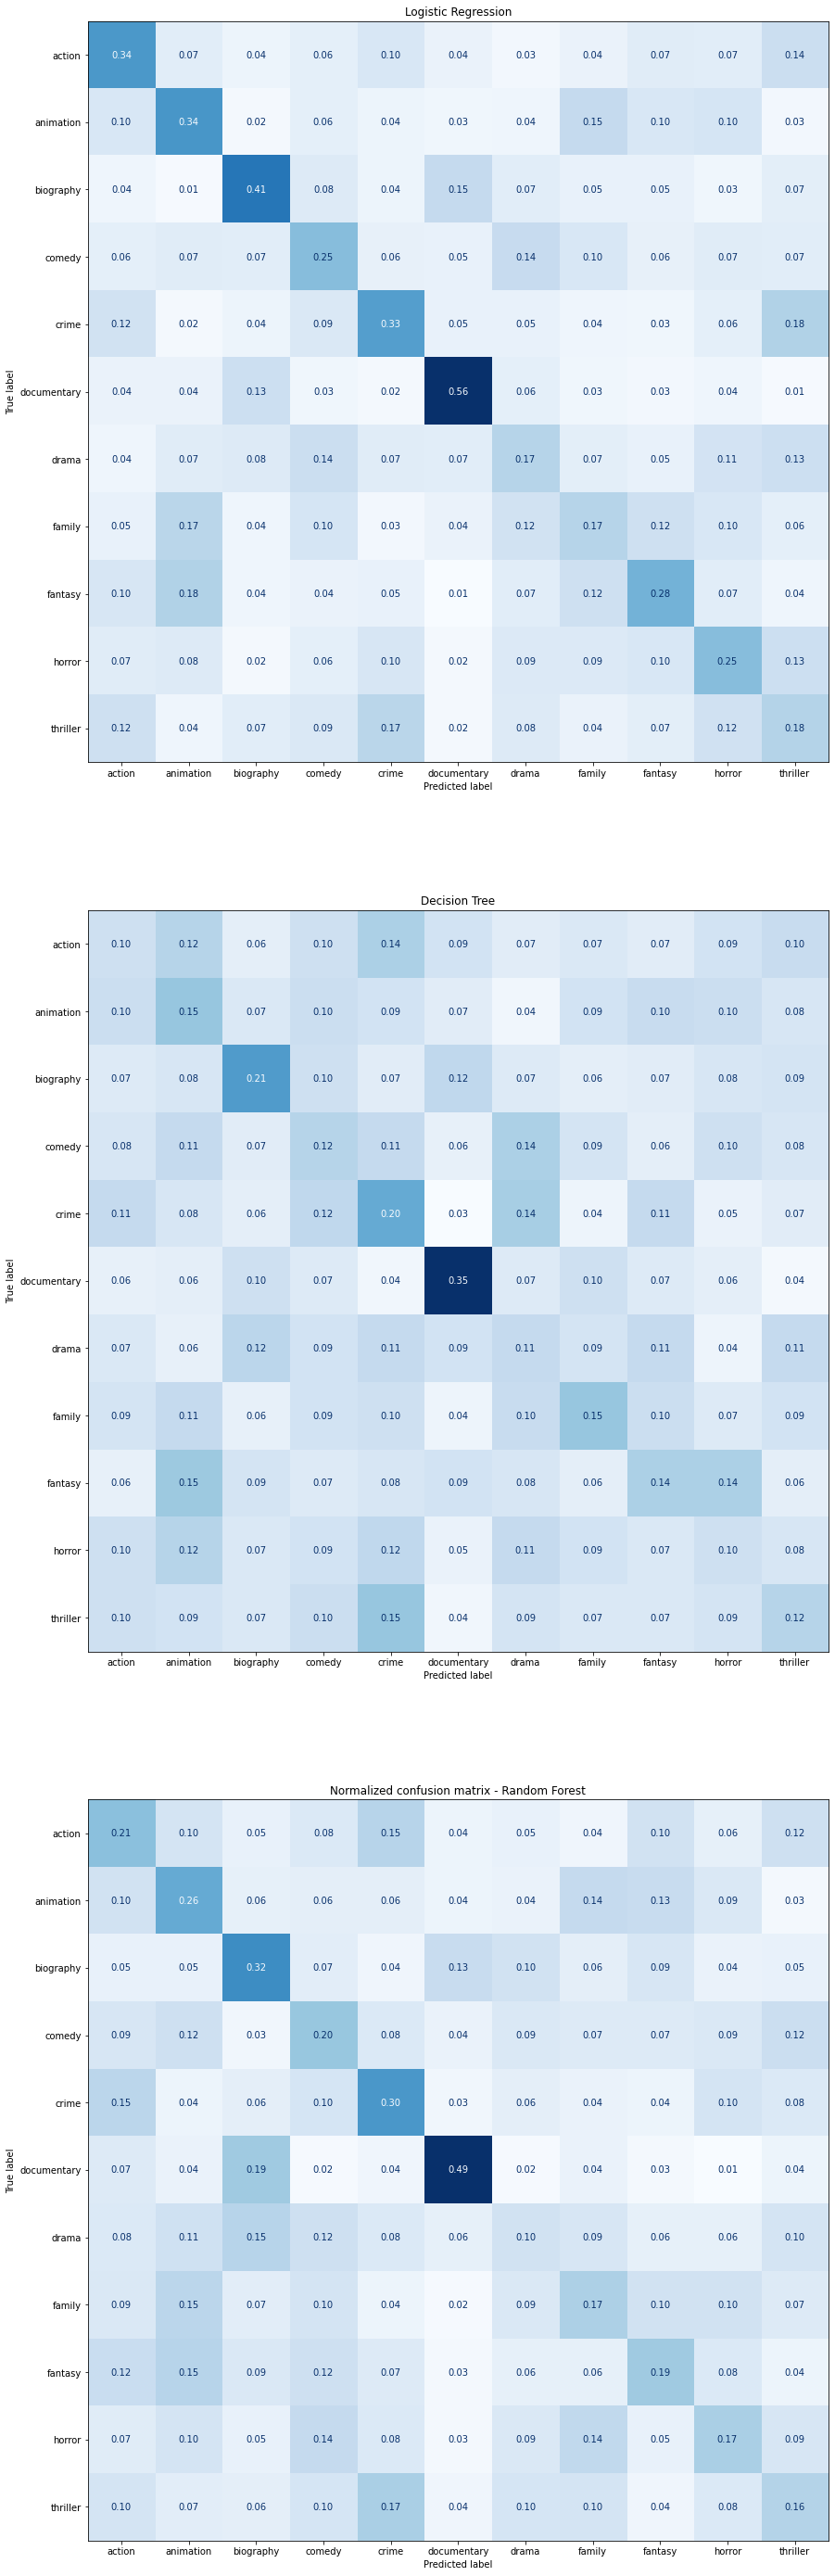

In [35]:
train_and_evaluate(filmweb_data_hidden, "dummy")

In [36]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.09090909090909091